### Collision checking

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from mujoco_parser import MuJoCoParserClass,get_env_obj_names,set_env_obj,set_env_objs,get_env_obj_poses
from pid import PID_ControllerClass
np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Ready.


### Parse `Panda` with objects

In [2]:
env = MuJoCoParserClass(name='Panda',xml_path='../asset/panda/franka_panda_w_objs.xml')
env.init_viewer(window_width=0.5,window_height=0.5,
                cam_azimuth=80.0,cam_distance=3.0,
                cam_elevation=-30.0,cam_lookat=np.array([0,0,1.5]))
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_rev_joint,
    k_p = 1000.0, k_i = 0.0, k_d = 100.0, # <= D gain is super important
    out_min = env.torque_range[env.rev_joint_idxs,0],
    out_max = env.torque_range[env.rev_joint_idxs,1],
    ANTIWU  = True)
print ("Done.")

Creating window glfw
Done.


In [3]:
env.print_env_info()

[Panda] Instantiated from [/Users/sj/Dropbox/Mac/Implementation/little-complex-mujoco-usage/asset/panda/franka_panda_w_objs.xml]
- Simulation timestep is [0.0020]sec and frequency is [500]HZ
- [Panda] has [29] bodies
 [00] body name:[world]
 [01] body name:[panda_base]
 [02] body name:[panda_pedestal]
 [03] body name:[panda_link_0]
 [04] body name:[panda_link_1]
 [05] body name:[panda_link_2]
 [06] body name:[panda_link_3]
 [07] body name:[panda_link_4]
 [08] body name:[panda_link_5]
 [09] body name:[panda_link_6]
 [10] body name:[panda_link_7]
 [11] body name:[right_hand]
 [12] body name:[panda_right_gripper]
 [13] body name:[panda_eef]
 [14] body name:[panda_leftfinger]
 [15] body name:[panda_finger_joint1_tip]
 [16] body name:[panda_rightfinger]
 [17] body name:[panda_finger_joint2_tip]
 [18] body name:[work_space]
 [19] body name:[obj_box_01]
 [20] body name:[obj_box_02]
 [21] body name:[obj_box_03]
 [22] body name:[obj_box_04]
 [23] body name:[obj_box_05]
 [24] body name:[obj_cyli

### Locate objects

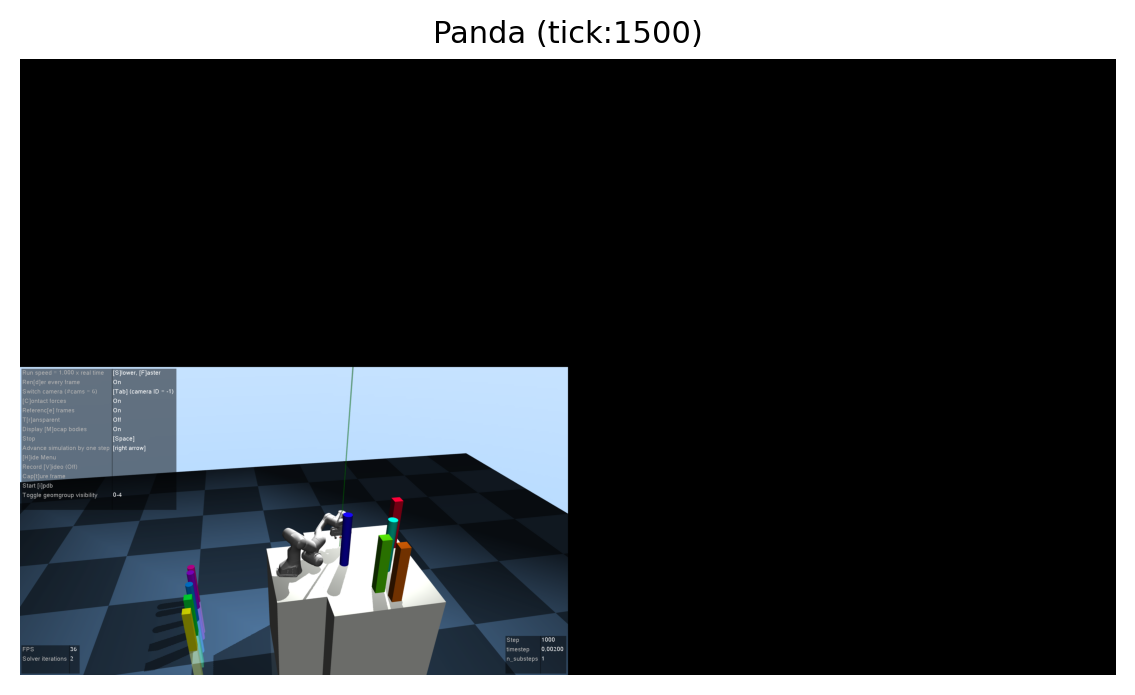

In [6]:
obj_names = get_env_obj_names(env,prefix='obj_') # see objects
obj_colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [-1.0,0.1*obj_idx,0.0]
    obj_quat  = [0,0,0,1]
    obj_color = obj_colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)
# Randomly place objects on the table
n_place  = 5
x_range  = [0.3,1.0]
y_range  = [-0.5,0.5]
z_range  = [1.01,1.01]
min_dist = 0.15
obj2place_idxs = np.random.permutation(len(obj_names))[:n_place].astype(int)
obj2place_names = [obj_names[o_idx] for o_idx in obj2place_idxs]
obj2place_poses = np.zeros((n_place,3))
for o_idx in range(n_place):
    while True:
        x = np.random.uniform(low=x_range[0],high=x_range[1])
        y = np.random.uniform(low=y_range[0],high=y_range[1])
        z = np.random.uniform(low=z_range[0],high=z_range[1])
        xyz = np.array([x,y,z])
        if o_idx >= 1:
            devc = cdist(xyz.reshape((-1,3)),obj2place_poses[:o_idx,:].reshape((-1,3)),'euclidean')
            if devc.min() > min_dist: break # minimum distance between objects
        else:
            break
    obj2place_poses[o_idx,:] = xyz
set_env_objs(env,obj_names=obj2place_names,obj_poses=obj2place_poses,obj_colors=None)
# Plot
env.forward_renders(max_tick=100)    
env.plot_scene(figsize=(8,4),title_str='Panda (tick:%d)'%(env.tick),title_fs=11)    

### Move end-effector by solving inverse kinematics with collsion check

In [5]:
# Zero-pose
q_des = np.array([0,0,0,0,0,90,0])*np.pi/180
env.forward(q_pos=q_des,q_pos_idxs=env.rev_joint_idxs,
            INCREASE_TICK=False)
# Open grasp with other joints remain the same
PID.reset()
max_tick  = 500
tick      = 0
while tick < max_tick:
    tick = tick + 1
    # PID control
    PID.update(x_trgt=q_des)
    PID.update(t_curr=env.get_sim_time(),x_curr=env.get_q_pos(q_pos_idxs=env.rev_joint_idxs),VERBOSE=False)
    torque = PID.out()
    env.step(ctrl=torque,ctrl_idxs=env.rev_joint_idxs)
    # Gripper
    env.step(ctrl=np.array([0.04,-0.04]),ctrl_idxs=env.pri_joint_idxs)
    # Render
    for c_idx in range(env.sim.data.ncon):
        contact    = env.sim.data.contact[c_idx]
        p_contact  = contact.pos
        bodyname1  = env.body_idx2name(env.sim.model.geom_bodyid[contact.geom1])
        bodyname2  = env.body_idx2name(env.sim.model.geom_bodyid[contact.geom2])
        label      = '%s-%s'%(bodyname1,bodyname2)
        env.add_marker(pos=p_contact,radius=0.05,color=np.array([1,0,0,0.2]),label='')
    env.render(RENDER_ALWAYS=False)
# Prepare for IK
body_name = 'panda_eef' # panda_eef / panda_link_4 / panda_link_5 / panda_link_6
q         = env.get_q_pos(q_pos_idxs=env.rev_joint_idxs)
p_EE      = env.get_p_body(body_name=body_name)
R_EE      = env.get_R_body(body_name=body_name)
p_trgt1   = np.array([0.5, -0.3, 1.1])
p_trgt2   = np.array([0.7, 0.0, 1.1])
p_trgt3   = np.array([0.5, 0.3, 1.1])
R_trgt    = np.diag([-1.0, 1.0, -1.0])
max_tick  = 500
err_list  = np.zeros(max_tick)
q_list    = np.zeros((max_tick,env.n_rev_joint))
tick      = 0
while tick < max_tick:
    tick = tick + 1
    if tick <= max_tick*1/3:
        p_trgt = p_trgt1
    elif tick <= max_tick*2/3:
        p_trgt = p_trgt2
    else:
        p_trgt = p_trgt3
    dq,err = env.one_step_ik(body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,stepsize=3.0*np.pi/180.0)
    q = q + dq
    # Update
    env.forward(q_pos=q,q_pos_idxs=env.rev_joint_idxs)
    env.add_marker(env.get_p_body(body_name),radius=0.025,color=np.array([1,0,0,0.1]))
    env.add_marker(p_trgt,radius=0.025,color=np.array([0,0,1,0.1]))
    # Collsion check
    for c_idx in range(env.sim.data.ncon):
        contact    = env.sim.data.contact[c_idx]
        p_contact  = contact.pos
        bodyname1  = env.body_idx2name(env.sim.model.geom_bodyid[contact.geom1])
        bodyname2  = env.body_idx2name(env.sim.model.geom_bodyid[contact.geom2])
        label      = '%s-%s'%(bodyname1,bodyname2)
        env.add_marker(pos=p_contact,radius=0.05,color=np.array([1,0,0,0.2]))
    # Render
    env.render(RENDER_ALWAYS=True)
print ("Done.")

Done.
